In [2]:
import pandas as pd

def ingest_train():
    data = pd.read_csv('data/dataset.csv', encoding="ISO-8859-1")
    data = data[data.Sentiment.isnull() == False]
    data['Sentiment'] = data['Sentiment'].map(int)
    data = data[data['SentimentText'].isnull() == False]
    data.reset_index(inplace=True)
    data.drop('index', axis=1, inplace=True)
    return data

train = ingest_train()
train.head()

,SentimentText,Sentiment
0,"first think another Disney movie, might good, ...",1
1,"Put aside Dr. House repeat missed, Desperate H...",0
2,"big fan Stephen King's work, film made even gr...",1
3,watched horrid thing TV. Needless say one movi...,0
4,truly enjoyed film. acting terrific plot. Jeff...,1


In [3]:
import re

pat_1 = r"(?:\@|https?\://)\S+"
pat_2 = r'#\w+ ?'
combined_pat = r'|'.join((pat_1, pat_2))
www_pat = r'www.[^ ]+'
html_tag = r'<[^>]+>'
negations_ = {"isn't":"is not", "can't":"can not","couldn't":"could not", "hasn't":"has not",
                "hadn't":"had not","won't":"will not",
                "wouldn't":"would not","aren't":"are not",
                "haven't":"have not", "doesn't":"does not","didn't":"did not",
                 "don't":"do not","shouldn't":"should not","wasn't":"was not", "weren't":"were not",
                "mightn't":"might not",
                "mustn't":"must not"}
negation_pattern = re.compile(r'\b(' + '|'.join(negations_.keys()) + r')\b')

from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()





def data_cleaner(text):
    try:
        stripped = re.sub(combined_pat, '', text)
        stripped = re.sub(www_pat, '', stripped)
        cleantags = re.sub(html_tag, '', stripped)
        lower_case = cleantags.lower()
        neg_handled = negation_pattern.sub(lambda x: negations_[x.group()], lower_case)
        letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
        tokens = tokenizer.tokenize(letters_only)
        return (" ".join(tokens)).strip()
    except:
        return 'NC'

In [4]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

def post_process(data, n=1000000):
    data = data.head(n)
    data['SentimentText'] = data['SentimentText'].progress_map(data_cleaner)  
    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    return data


train = post_process(train)

progress-bar: 100%|████████████████████████████████████████████████████████████| 25000/25000 [00:08<00:00, 2940.12it/s]


In [5]:
clean_data = pd.DataFrame(train,columns=['SentimentText'])
clean_data['Sentiment'] = train.Sentiment

clean_data.to_csv('clean_data.csv',encoding='utf-8')

csv = 'clean_data.csv'
data = pd.read_csv(csv,index_col=0)
data.head()


,SentimentText,Sentiment
0,first think another disney movie might good it...,1
1,put aside dr house repeat missed desperate hou...,0
2,big fan stephen king s work film made even gre...,1
3,watched horrid thing tv needless say one movie...,0
4,truly enjoyed film acting terrific plot jeff c...,1


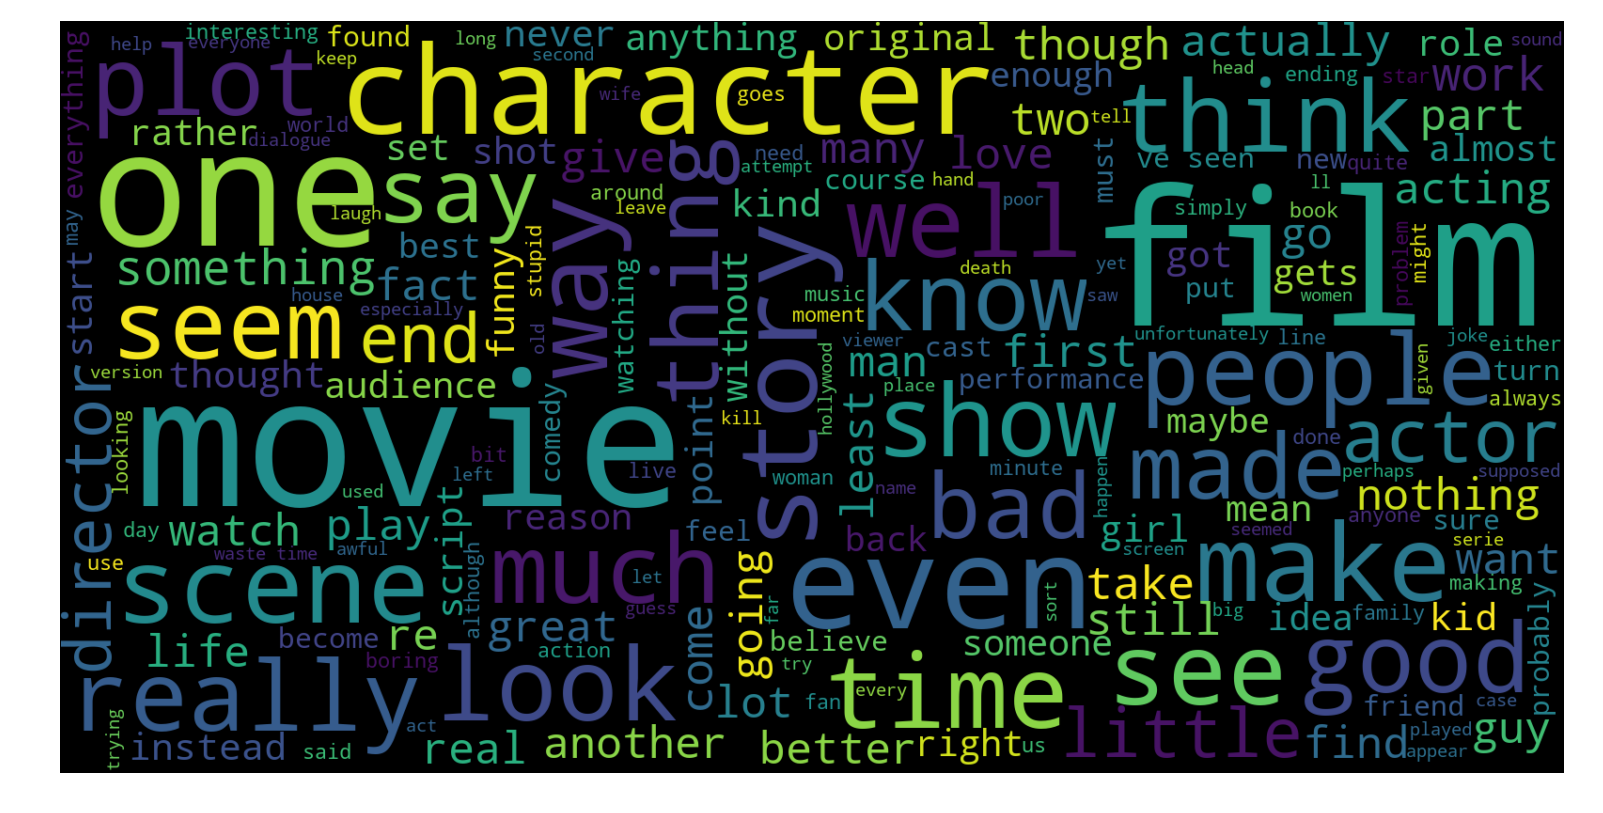

In [6]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from wordcloud import WordCloud, STOPWORDS


neg_tweets = train[train.Sentiment == 0]
neg_string = []
for t in neg_tweets.SentimentText:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

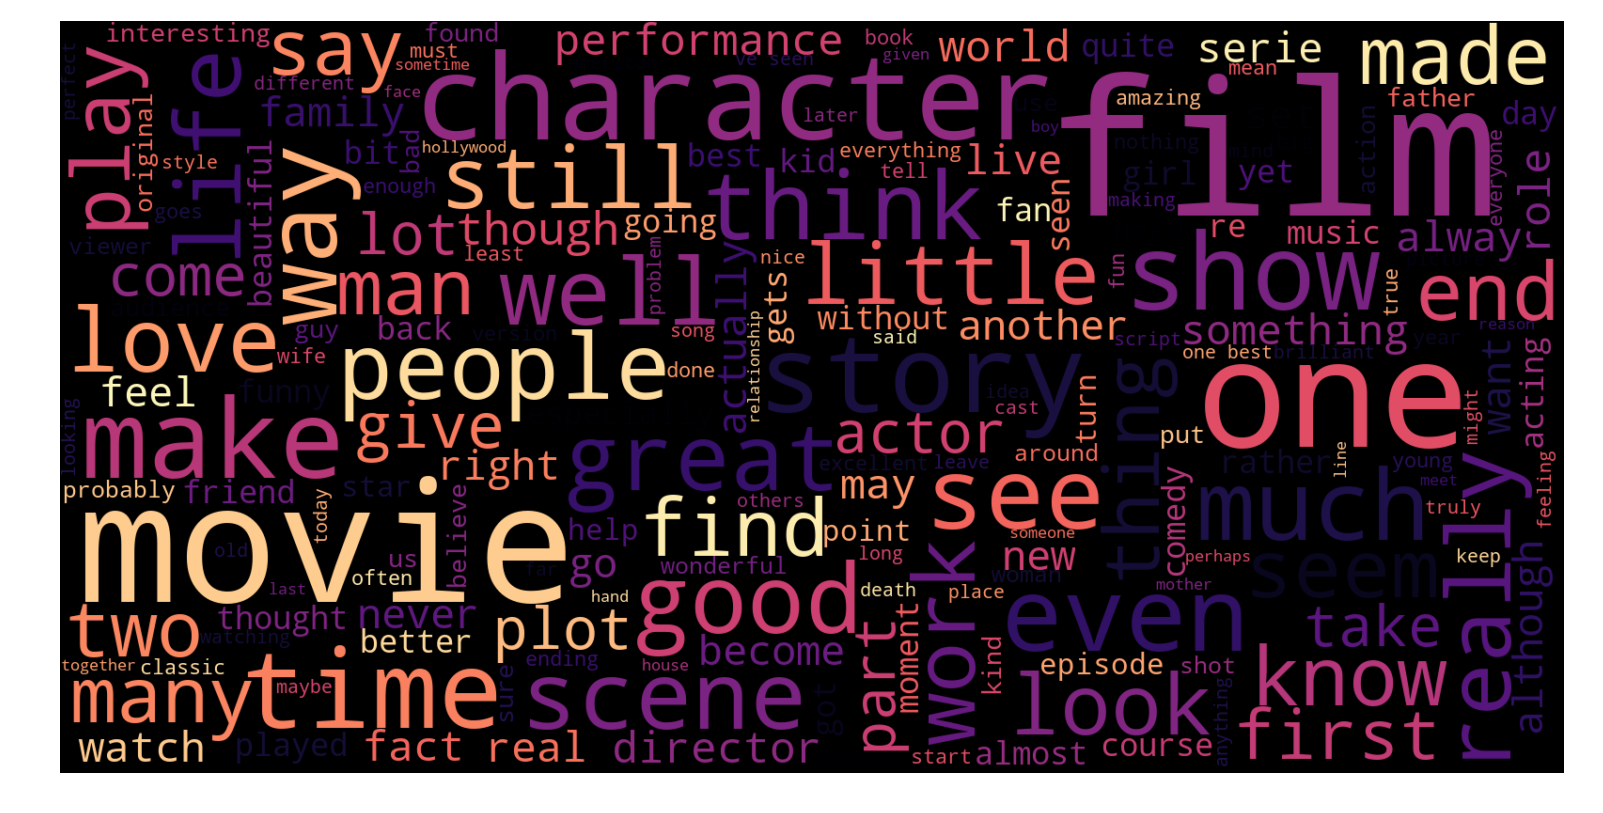

In [7]:
pos_tweets = train[train.Sentiment == 1]
pos_string = []
for t in pos_tweets.SentimentText:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(pos_string) 
plt.figure(figsize=(12,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

In [8]:
#Spliting The Data
from sklearn.cross_validation import train_test_split
SEED = 2000

x_train, x_validation, y_train, y_validation = train_test_split(train.SentimentText, train.Sentiment, test_size=.2, random_state=SEED)




from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 
import numpy as np
from time import time


def acc_summary(pipeline, x_train, y_train, x_test, y_test):
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    print("train and test time: {0:.2f}s".format(train_test_time))
    print("-"*80)
    return accuracy, train_test_time


from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()

from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel

names = ["Logistic Regression", "Linear SVC", "LinearSVC with L1-based feature selection","Multinomial NB", 
         "Bernoulli NB", "Ridge Classifier", "AdaBoost", "Perceptron","Passive-Aggresive", "Nearest Centroid"]
classifiers = [
    LogisticRegression(),
    LinearSVC(),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))]),
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(),
    AdaBoostClassifier(),
    Perceptron(),
    PassiveAggressiveClassifier(),
    NearestCentroid()
    ]
zipped_clf = zip(names,classifiers)

tvec = TfidfVectorizer()
def classifier_comparator(vectorizer=tvec, n_features=10000, stop_words=None, ngram_range=(1, 1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print("Validation result for {}".format(n))
        print(c)
        clf_acc,tt_time = acc_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,clf_acc,tt_time))
    return result



C:\Users\pattn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\pattn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [9]:
trigram_result = classifier_comparator(n_features=100000,ngram_range=(1,3))

Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
accuracy score: 89.36%
train and test time: 34.74s
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
accuracy score: 90.48%
train and test time: 37.39s
--------------------------------------------------------------------------------
Validation result for LinearSVC with L1-based feature selection
Pipeline(memory=None,
     steps=[('feature_selection', SelectFromModel(estimator=LinearSVC(C=1.0, class_weight=None,

C:\Users\pattn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


accuracy score: 89.02%
train and test time: 35.55s
--------------------------------------------------------------------------------
Validation result for Passive-Aggresive
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              fit_intercept=True, loss='hinge', max_iter=None, n_iter=None,
              n_jobs=1, random_state=None, shuffle=True, tol=None,
              verbose=0, warm_start=False)


C:\Users\pattn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


accuracy score: 90.32%
train and test time: 34.04s
--------------------------------------------------------------------------------
Validation result for Nearest Centroid
NearestCentroid(metric='euclidean', shrink_threshold=None)
accuracy score: 81.50%
train and test time: 34.39s
--------------------------------------------------------------------------------
